---
title: AERO 417 Project 1
---

In [1]:
import numpy as np
from scipy.optimize import fsolve
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sy

## Constant Mean Diameter (CMD)

In [2]:
# Input Constraints
takeoff_thrust = 12000
pressure_ambient = 1.01
temperature_ambient = 288

P_compressor = 4.15
m_dot = 20
turbine_inlet_temperature = 1100

Cp = 1005
gamma = 1.4
R = 287

compressor_polytropic_efficiency = 0.9
n_compressor = -1/(1/compressor_polytropic_efficiency*(gamma-1)/gamma-1)

# Design Variables
N = 250
U_tip = 355.3
C_axial = 150
rr_rt = 0.5

### Compressor Geometry

Geometry:
Inlet
Tip- 0.22613177899925122
Root- 0.11306588949962561
Mean- 0.16959883424943842
Outlet
Tip- 0.1902343302069359
Root- 0.14896333829194094
Mean- 0.16959883424943842


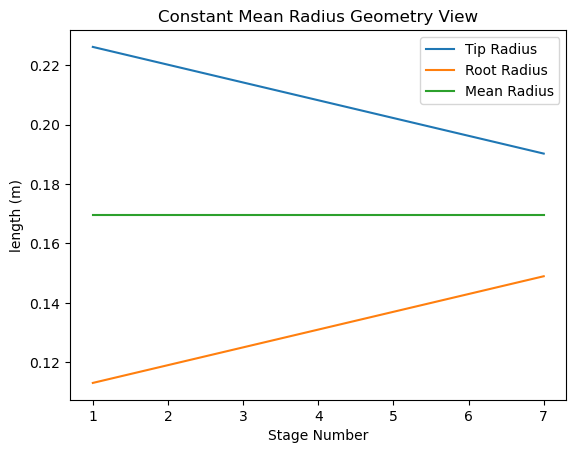

In [3]:
T01 = temperature_ambient
P01 = pressure_ambient
C1 = C_axial

T1 = T01-C1**2/2/Cp
P1 = P01*(T1/T01)**(gamma/(gamma-1))
rho1 = P1/R/T1*100000

inlet_radius_tip = (m_dot/(np.pi*rho1*C1)/(1-rr_rt**2))**0.5
inlet_radius_root = rr_rt*inlet_radius_tip
inlet_radius_mean = (inlet_radius_tip+inlet_radius_root)/2

V1_tangent = (U_tip**2+C_axial**2)**0.5
a1 = (gamma*R*T1)**0.5
M1 = V1_tangent/a1

C2 = C1
T02 = T01*(P_compressor)**((n_compressor-1)/n_compressor)
P02 = P_compressor*P01
T2 = T02-C2**2/2/Cp
P2 = P02*(T2/T02)**(gamma/(gamma-1))
rho2 = P2/R/T2*100000
A2 = m_dot/rho2/C2

outlet_radius_mean = inlet_radius_mean
h = A2/2/np.pi/outlet_radius_mean
outlet_radius_tip = outlet_radius_mean+h/2
outlet_radius_root = outlet_radius_mean-h/2

print("Geometry:")
print("Inlet")
print("Tip-",inlet_radius_tip)
print("Root-",inlet_radius_root)
print("Mean-",inlet_radius_mean)
print("Outlet")
print("Tip-",outlet_radius_tip)
print("Root-",outlet_radius_root)
print("Mean-",outlet_radius_mean)

U_mean = 2*np.pi*N*outlet_radius_mean
Beta1 = np.arctan(U_mean/C_axial)
V1 = C_axial/np.cos(Beta1)
V2 = 0.72*V1
Beta2 = np.arccos(C_axial/V2)

ideal_temperature_rise = U_mean*C_axial*(np.tan(Beta1)-np.tan(Beta2))/Cp
num_stages = int(np.ceil((T2-T1)/ideal_temperature_rise)+1)

tips = np.linspace(inlet_radius_tip,outlet_radius_tip,num_stages)
roots = np.linspace(inlet_radius_root,outlet_radius_root,num_stages)
means = [(t+r)/2 for t,r in zip(tips,roots)]

x = range(1,num_stages+1)

plt.figure()
plt.plot(x,tips,label="Tip Radius")
plt.plot(x,roots,label="Root Radius")
plt.plot(x,means,label="Mean Radius")
plt.legend()
plt.xticks(x)
plt.xlabel("Stage Number")
plt.ylabel("length (m)")
plt.title("Constant Mean Radius Geometry View")
plt.show()

In [4]:
mean_temperature_rise = (T2-T1)/num_stages

min_temperature_rise = mean_temperature_rise-mean_temperature_rise%(np.ceil(mean_temperature_rise/5))
max_temperature_rise = ((T2-T1)-2*min_temperature_rise)/(num_stages-2)
temperature_rise = []
temperature_rise.append(min_temperature_rise)
temperature_rise.extend((num_stages-2)*[max_temperature_rise])
temperature_rise.append(min_temperature_rise)

work_done = [max(0.98-i*0.05,0.83) for i in range(num_stages)]

C1_swirl = [0]

swirl_change = Cp*temperature_rise[0]/work_done[0]/U_mean
C2_swirl = [C1_swirl[-1]+swirl_change]

Beta1 = np.arctan(U_mean/C_axial)
Alpha1 = np.arctan(C1_swirl[-1]/C_axial)
Beta2 = np.arctan((U_mean-C2_swirl[-1])/C_axial)
Alpha2 = np.arctan(C2_swirl[-1]/C_axial)

De_Haller = [np.cos(Beta1)/np.cos(Beta2)]

P_ratio = [(1+compressor_polytropic_efficiency*temperature_rise[0]/T01)**(gamma/(gamma-1))]

Inlet_P0 = [P01]
Outlet_P0 = [P_ratio[-1]*P01]

Inlet_T0 = [T01]
Outlet_T0 = [T01+temperature_rise[0]]

Lambda = [1-(C2_swirl[-1]+C1_swirl[-1])/2/U_mean,0.7]
Lambda.extend((num_stages-2)*[0.5])

def beta_equations(x,idx):
    return [temperature_rise[idx]*Cp/work_done[idx]/U_mean/C_axial-(np.tan(x[0])-np.tan(x[1])),
            Lambda[idx]/C_axial*2*U_mean-(np.tan(x[0])+np.tan(x[1]))]

for stage_num in range(1,num_stages):
    Beta1,Beta2 = fsolve(beta_equations,[1,1],args=stage_num)
    Alpha1 = np.arctan(U_mean/C_axial-np.tan(Beta1))
    Alpha2 = np.arctan(U_mean/C_axial-np.tan(Beta2))
    C1_swirl.append(C_axial*np.tan(Alpha1))
    C2_swirl.append(C_axial*np.tan(Alpha2))
    De_Haller.append(np.cos(Beta1)/np.cos(Beta2))
    P_ratio.append((1+compressor_polytropic_efficiency*temperature_rise[stage_num]/Outlet_T0[-1])**(gamma/(gamma-1)))
    Inlet_P0.append(Outlet_P0[-1])
    Outlet_P0.append(P_ratio[-1]*Inlet_P0[-1])
    Inlet_T0.append(Outlet_T0[-1])
    Outlet_T0.append(Inlet_T0[-1]+temperature_rise[stage_num])
    
df = {"Inlet_T0":Inlet_T0,
      "Outlet_T0":Outlet_T0,
      "Inlet_P0":Inlet_P0,
      "Outlet_P0":Outlet_P0,
      "P_ratio":P_ratio,
      "Inlet_swirl":C1_swirl,
      "Outlet_swirl":C2_swirl,
      "De_Haller":De_Haller}
df = pd.DataFrame(df)
df.index+=1
df

,Inlet_T0,Outlet_T0,Inlet_P0,Outlet_P0,P_ratio,Inlet_swirl,Outlet_swirl,De_Haller
1,288.000000,308.000000,1.010000,1.248742,1.236378,0.000000,76.988745,0.790290
2,308.000000,332.895759,1.248742,1.596665,1.278619,29.428035,130.415100,0.721912
3,332.895759,357.791519,1.596665,2.005517,1.256066,79.840130,186.565096,0.709831
4,357.791519,382.687278,2.005517,2.480587,1.236881,76.625522,189.779704,0.696310
5,382.687278,407.583037,2.480587,3.027218,1.220364,76.625522,189.779704,0.696310
6,407.583037,432.478797,3.027218,3.650806,1.205994,76.625522,189.779704,0.696310
7,432.478797,452.478797,3.650806,4.210873,1.153409,87.751426,178.653800,0.744968


## Constant Outer Diameter (COD)

$$
\begin{array}{|c|c|}
    \hline
    \text{\textbf{Parameter}} & \text{\textbf{Value}} \\
    \hline
    \text{Inlet stagnation pressure} & 101,325 \, \text{Pa} \\
    \hline
    \text{Inlet stagnation temperature} & 288.15 \, \text{K} \\
    \hline
    \text{Mass flow} & 8.1 \, \text{kg/s} \\
    \hline
    \text{Inlet Mach number} & 0.50 \\
    \hline
    \text{Outlet Mach number} & 0.26 \\
    \hline
    \text{Pressure ratio} & 5.0 \\
    \hline
    \text{Polytropic efficiency} & 89\% \\
    \hline
    \text{Number of stages} & 5 \\
    \hline
    \text{Rotational speed} & 25,650 \, \text{rpm} \\
    \hline
    \text{Inlet hub-tip-ratio} & 0.40 \\
    \hline
    \text{Axial channel} & \text{COD} \\
    \hline
\end{array}
$$


In [5]:
# Input Constraints
takeoff_thrust = 5096
P01 = 1.01325
T01 = 288.15

P_compressor = 5
m_dot = 8.10
turbine_inlet_temperature = 1173

Cp = 1005
gamma = 1.4
R = 287

compressor_polytropic_efficiency = 0.89
n_compressor = -1/(1/compressor_polytropic_efficiency*(gamma-1)/gamma-1)

# Design Variables
N = 25650/60
rr_rt = 0.4
M1 = 0.5
M2 = 0.26

num_stages = 5

### Inlet Axial Flow

Using these specifications, we can start to put together the compressor geometry. However, we need to fix the axial flow of the compressor. To do this, we can solve for the incoming fluid speed, using the inlet mach number.

$$
\begin{aligned}
a_{1} & = \sqrt{\gamma R T_{1}} \\
T_{1} & = T_{01} - \frac{C_1^2}{2C_p} \\
C_{1} & = a_{1} M_{1} \\
          & = \sqrt{\gamma R T_{1}} M_{1} \\
          & = (0.5)\sqrt{1.4(287)(288.15-\frac{C_1^2}{2010})} \\
C_{1} & = 166.0331 \text{ m/s}
\end{aligned}
$$

In [6]:
Ca = sy.Symbol("C_a")
T1 = T01-Ca**2/2/Cp
a1 = (gamma*R*T1)**0.5
C_axial = float(sy.solve(M1*a1-Ca,Ca)[0])

### Compressor Geometry

#### Inlet Temperature and Pressure Calculations

$$
\begin{align*}
C_1 &= C_{\text{ax}} \\
T_1 &= T_{01} - \frac{C_1^2}{2 C_p} \\
P_1 &= P_{01} \left( \frac{T_1}{T_{01}} \right)^{\frac{\gamma}{\gamma - 1}} \\
\rho_1 &= \frac{P_1}{R T_1} \times 10^5
\end{align*}
$$

In [7]:
C1 = C_axial
T1 = T01-C1**2/2/Cp
P1 = P01*(T1/T01)**(gamma/(gamma-1))
rho1 = P1/R/T1*100000

#### Inlet Radius Calculations

$$
\begin{align*}
r_{\text{t},1} &= \sqrt{\frac{\dot{m}}{\pi \cdot \rho_1 \cdot C_1 \cdot (1 - \frac{r_{t}}{r_{r}}^2)}} \\
r_{\text{r},1} &= rr_{rt} \cdot r_{\text{t},1} \\
r_{\text{m},1} &= \frac{r_{\text{m},1} + r_{\text{r},1}}{2}
\end{align*}
$$

In [8]:
inlet_radius_tip = (m_dot/(np.pi*rho1*C1)/(1-rr_rt**2))**0.5
inlet_radius_root = rr_rt*inlet_radius_tip
inlet_radius_mean = (inlet_radius_tip+inlet_radius_root)/2

#### Outlet Temperature and Pressure Calculations

$$
\begin{align*}
C_2 &= C_1 \\
T_{02} &= T_{01} \cdot \left(\frac{P_{02}}{P_{01}}\right)^{\frac{n- 1}{n}} \\
P_{02} &= \left(\frac{P_{02}}{P_{01}}\right) \cdot P_{01} \\
T_2 &= T_{02} - \frac{C_2^2}{2 C_p} \\
a_2 &= \sqrt{\gamma \cdot R \cdot T_2} \\
P_2 &= P_{02} \left( \frac{T_2}{T_{02}} \right)^{\frac{\gamma}{\gamma - 1}} \\
\rho_2 &= \frac{P_2}{R T_2} \times 10^5 \\
A_2 &= \frac{\dot{m}}{\rho_2 \cdot C_2}
\end{align*}
$$

In [9]:
C2 = C1
T02 = T01*(P_compressor)**((n_compressor-1)/n_compressor)
P02 = P_compressor*P01
T2 = T02-C2**2/2/Cp
a2 = (gamma*R*T2)**0.5

P2 = P02*(T2/T02)**(gamma/(gamma-1))
rho2 = P2/R/T2*100000
A2 = m_dot/rho2/C2


#### Outlet Radius Calculations
$$
\begin{align*}
r_{\text{t},2} &= r_{\text{t},1} \\
r_{\text{r},2} &= \sqrt{r_{\text{t},2}^2 - \frac{A_2}{\pi}} \\
r_{\text{m},2} &= \frac{r_{\text{t},2} + r_{\text{r},2}}{2}
\end{align*}
$$

In [10]:
outlet_radius_tip = inlet_radius_tip
outlet_radius_root = (outlet_radius_tip**2-A2/np.pi)**0.5
outlet_radius_mean = (outlet_radius_tip+outlet_radius_root)/2

print("Geometry:")
print("Inlet")
print("Tip-",inlet_radius_tip)
print("Root-",inlet_radius_root)
print("Mean-",inlet_radius_mean)
print("Outlet")
print("Tip-",outlet_radius_tip)
print("Root-",outlet_radius_root)
print("Mean-",outlet_radius_mean)

Geometry:
Inlet
Tip- 0.13055582635997443
Root- 0.052222330543989774
Mean- 0.0913890784519821
Outlet
Tip- 0.13055582635997443
Root- 0.11170496580778519
Mean- 0.12113039608387981


### Compressor Stages

#### Assuming Linear Root Variance

To advance the compressor design, we need to make an assumption regarding its geometry. For simplicity and feasibility, we will assume that the dimensions of the compressor stages vary linearly along the axis. This linear variation is a common approach that provides a baseline for initial design calculations. While this assumption allows us to proceed with modeling and analysis, alternative methods could potentially yield more accurate or optimized results, especially in cases where non-linear stage variation might better match performance requirements or efficiency goals. Future iterations may explore these options for refinement.

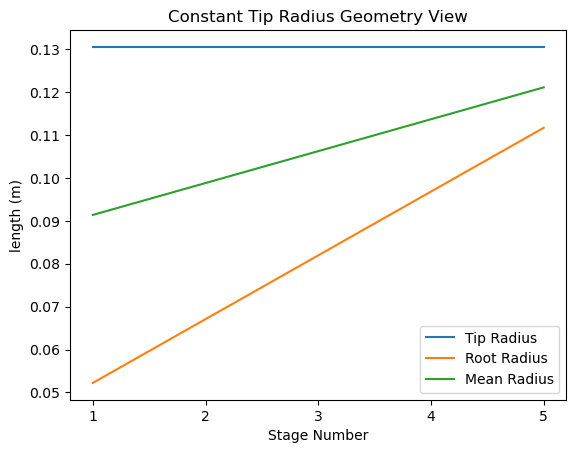

In [11]:
tips = np.linspace(inlet_radius_tip,outlet_radius_tip,num_stages)
roots = np.linspace(inlet_radius_root,outlet_radius_root,num_stages)
means = [(t+r)/2 for t,r in zip(tips,roots)]
U_mean = [2*np.pi*N*m for m in means]

x = range(1,num_stages+1)

plt.figure()
plt.plot(x,tips,label="Tip Radius")
plt.plot(x,roots,label="Root Radius")
plt.plot(x,means,label="Mean Radius")
plt.legend()
plt.xticks(x)
plt.xlabel("Stage Number")
plt.ylabel("length (m)")
plt.title("Constant Tip Radius Geometry View")
plt.show()

In [12]:
# Assuming the work done remains consistent with previous calculations and that the temperature rise varies linearly:

work_done = [max(0.98-i*0.05,0.83) for i in range(num_stages)]
temperature_rise = [(T02-T01)/num_stages for _ in range(num_stages)]

$$
\begin{align*}
C_{w,1} &= 0 \\
C_{w,2} &= \frac{\frac{C_p \Delta T_{12}}{\lambda_0}+U_{1}C_{w,1}}{U_2} \\
\end{align*}
$$

$$
\begin{align*}
\beta_1 &= \tan^{-1} \left( \frac{U_{\text{m,1}}}{C_{\text{axial}}} \right) \\
\alpha_1 &= \tan^{-1} \left( \frac{C_{w,1}}{C_{\text{axial}}} \right) \\
\beta_2 &= \tan^{-1} \left( \frac{U_{\text{m,1}} - C_{w,2}}{C_{\text{axial}}} \right) \\
\alpha_2 &= \tan^{-1} \left( \frac{C_{w,2}}{C_{\text{axial}}} \right)
\end{align*}
$$

In [13]:
C1_swirl = [0]
C2_swirl = [(Cp*temperature_rise[0]/work_done[0]+U_mean[0]*C1_swirl[-1])/U_mean[1]]

Beta1 = np.arctan(U_mean[0]/C_axial)
Alpha1 = np.arctan(C1_swirl[0]/C_axial)
Beta2 = np.arctan((U_mean[0]-C2_swirl[0])/C_axial)
Alpha2 = np.arctan(C2_swirl[0]/C_axial)
    
De_Haller = [np.cos(Beta1)/np.cos(Beta2)]

P_ratio = [(1+compressor_polytropic_efficiency*temperature_rise[0]/T01)**(gamma/(gamma-1))]

Inlet_P0 = [P01]
Outlet_P0 = [P_ratio[0]*P01]

Inlet_T0 = [T01]
Outlet_T0 = [T01+temperature_rise[0]]

Lambda = [1-(C2_swirl[0]+C1_swirl[0])/2/U_mean[0],0.7]
Lambda.extend((num_stages-2)*[0.5])

def beta_equations(x,idx):
    return [temperature_rise[idx]*Cp/work_done[idx]/C_axial/U_mean[idx]-(np.tan(x[0])-np.tan(x[1])),
            Lambda[idx]/C_axial*2*U_mean[idx]-(np.tan(x[0])+np.tan(x[1]))]

for stage_num in range(1,num_stages):
    Beta1,Beta2 = fsolve(beta_equations,[1,1],args=stage_num)
    Alpha1 = np.arctan(U_mean[stage_num]/C_axial-np.tan(Beta1))
    Alpha2 = np.arctan(U_mean[stage_num]/C_axial-np.tan(Beta2))
    C1_swirl.append(C_axial*np.tan(Alpha1))
    C2_swirl.append(C_axial*np.tan(Alpha2))
    De_Haller.append(np.cos(Beta1)/np.cos(Beta2))
    P_ratio.append((1+compressor_polytropic_efficiency*temperature_rise[stage_num]/Outlet_T0[-1])**(gamma/(gamma-1)))
    Inlet_P0.append(Outlet_P0[-1])
    Outlet_P0.append(P_ratio[-1]*Inlet_P0[-1])
    Inlet_T0.append(Outlet_T0[-1])
    Outlet_T0.append(Inlet_T0[-1]+temperature_rise[stage_num])
    
df = {"Inlet_T0":Inlet_T0,
      "Outlet_T0":Outlet_T0,
      "Inlet_P0":Inlet_P0,
      "Outlet_P0":Outlet_P0,
      "P_ratio":P_ratio,
      "Inlet_swirl":C1_swirl,
      "Outlet_swirl":C2_swirl,
      "De_Haller":De_Haller}
df = pd.DataFrame(df)
df.index+=1
df

,Inlet_T0,Outlet_T0,Inlet_P0,Outlet_P0,P_ratio,Inlet_swirl,Outlet_swirl,De_Haller
1,288.150000,327.133333,1.013250,1.508452,1.488726,0.000000,150.604776,0.645264
2,327.133333,366.116666,1.508452,2.146616,1.423059,0.283634,158.985441,0.630430
3,366.116666,405.099998,2.146616,2.946985,1.372852,64.718541,220.701671,0.645230
4,405.099998,444.083331,2.946985,3.929042,1.333241,75.413809,229.978157,0.642898
5,444.083331,483.066664,3.929042,5.112488,1.301205,90.143486,235.220234,0.656183


## Lessons Learned

One key insight I've gained is that often, reaching a conclusion requires making certain assumptions along the way.